#  MFCC updates in Essentia

MFCC computation steps
* Audio-> Spectrum->Mel Band Energies->log->DCT-> MFCC

Different implementations
* Slaney's  (auditory toolbox)
* htk (htk toolbox)
* Essentia (based on Slaney)
* librosa (based on Slaney)
* MIR toolbox (based on Slaney)
* ...

Parametrs for MFCCs in Essentia so far
* min and max frequencies
* number of mel bands
* number of MFCCs

Added parameters
* spectrum type:
    * power Vs  magnitude
* frequency to mel warping function
    * slaneyMel Vs htkMel
*  weghting of filter coefficients
    * linear (triangles in Hz) Vs warped (triangles in Mel)
* normalize filters
    *  same area Vs same height
* log type 
    * log, log10, None
* liftering

## example 1:  <br/>  Essentia MFCCs: default (Slaney)  Vs htk 

In [2]:
### load audio

import essentia
import essentia.standard as ess
import matplotlib.pyplot as plt
import numpy as np


filename = 'audio/vignesh.wav'
fs = 44100
audio = ess.MonoLoader(filename = filename, 
                                          sampleRate = fs)()

# audio = audio*2**15 # dynamic range expansion as done in HTK implementation


    
hopSize = 1024 
frameSize = fftSize = 2048
spectrumSize= fftSize//2+1

w = ess.Windowing(type = 'hamming', #  corresponds to htk default  USEHAMMING = T
                        size = fftSize, 
                        normalized = False,
                        zeroPhase = False)
spectrum = ess.Spectrum(size = fftSize)


Parameters that make big difference
* spectrum type:
    * power Vs magnitude
* triangular filterbank shape: 
    * unit_max Vs unit_sum
    <img style="height:220px;" src='https://cloud.githubusercontent.com/assets/5612394/20187945/be25b48e-a776-11e6-81e0-885de17165f3.png'>
* liftering after DCT

In [80]:
# initialize mfcc parameters
NUM_BANDS  = 26
DCT_TYPE = 2
LIFTERING = 22
NUM_MFCCs = 13
HIGH_FREQ_BOUND = 8000 

mfcc_slaney = ess.MFCC(inputSize = spectrumSize,
                    type = 'power',
                    normalize = 'unit_sum',
                    liftering = 0,                    
                    highFrequencyBound = HIGH_FREQ_BOUND,
                    numberBands = NUM_BANDS,
                    numberCoefficients = NUM_MFCCs)

mfcc_htk = ess.MFCC(inputSize = spectrumSize,
                        type = 'magnitude', # htk uses mel filterbank magniude
                        normalize = 'unit_max', # htk filter normaliation to have constant height = 1
                        liftering = LIFTERING, # corresponds to htk default CEPLIFTER = 22
                        warpingFormula = 'htkMel', # htk's mel warping formula
                        weighting = 'linear', # computation of filter weights done in Hz domain
                        highFrequencyBound = HIGH_FREQ_BOUND, # corresponds to htk default
                        lowFrequencyBound = 0, # corresponds to htk default
                        numberBands = NUM_BANDS, # corresponds to htk default  NUMCHANS = 26
                        numberCoefficients = NUM_MFCCs, 
                        dctType = 3, # htk uses DCT type III
                        logType = 'log')
                        

In [92]:
# computation 

mel_bands_slaney = []
mfccs_slaney = []

mel_bands_htk = []
mfccs_htk = []

    # startFromZero = True, validFrameThresholdRatio = 1 : the way htk computes windows
for frame in ess.FrameGenerator(audio, frameSize = frameSize, hopSize = hopSize):
        
       
        spect = spectrum(w(frame))

        mel_bands, mfcc_coeffs = mfcc_slaney(spect)
        mel_bands_slaney.append(mel_bands)
        mfccs_slaney.append(mfcc_coeffs)
        
        mel_bands, mfcc_coeffs = mfcc_htk(spect)
        mel_bands_htk.append(mel_bands)
        mfccs_htk.append(mfcc_coeffs)

mel_bands_slaney = essentia.array(mel_bands_slaney).T
mel_bands_htk = essentia.array(mel_bands_htk).T

mfccs_slaney = essentia.array(mfccs_slaney).T
mfccs_htk = essentia.array(mfccs_htk).T



In [93]:
# visualize mel bands

def visualize_mel_bands(mel_bands, title, which_figure):
    import librosa
    plt.subplot(2, 1, which_figure)
    librosa.display.specshow(mel_bands, sr=44100, hop_length=hopSize, x_axis='time', y_axis='mel', fmax=HIGH_FREQ_BOUND)
    plt.colorbar(); plt.title(title)

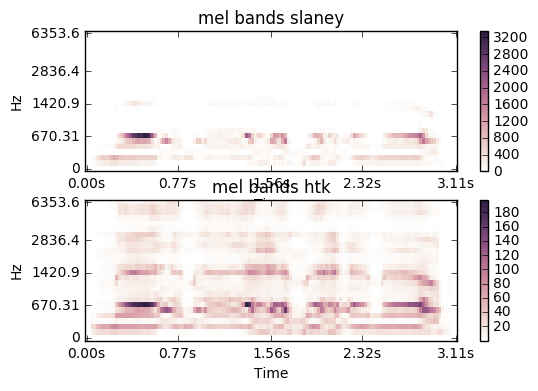

In [94]:
#### plot mel bands
 
visualize_mel_bands(mel_bands_slaney, 'mel bands slaney', 1)
visualize_mel_bands(mel_bands_htk, 'mel bands htk', 2)
plt.show() 

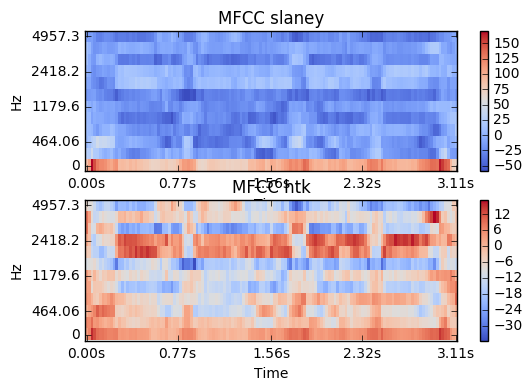

In [97]:
#### plot mfccs
visualize_mel_bands(mfccs_slaney[1:,:], 'MFCC slaney', 1) # do not show MFCC 0 (energy)
visualize_mel_bands(mfccs_htk[1:,:], 'MFCC htk', 2)
plt.show() 


## why is supporting htk's mfcc type in essentia important?
* license 
* reproducibility of research work
* extensibility